## Face Swap App

In this project I will extract human faces from images using OpenCV and Dlib. I will be using a pre-trained model to extract the faces using human face landmarks.  

This project can be used for learning and understanding different concepts of computer vision;  the applications can be things like Augmented Reality applications like Snapchat etc. 

In [ ]:
# import the libraries
import cv2
import numpy as np
import dlib
import requests
from PIL import Image

Downloading the pre-trained model

In [ ]:
!wget ="https://github.com/tzutalin/dlib-android/raw/master/data/shape_predictor_68_face_landmarks.dat"

I will now create a function to extract the index from the numpy array. 

In [ ]:
def extract_index_nparray(nparray):
  index = None
  for num in nparray[0]:
    index = num
    break
  return index

Now,  I am going to pull some images from the internet, my facebook and a friends facebook. 

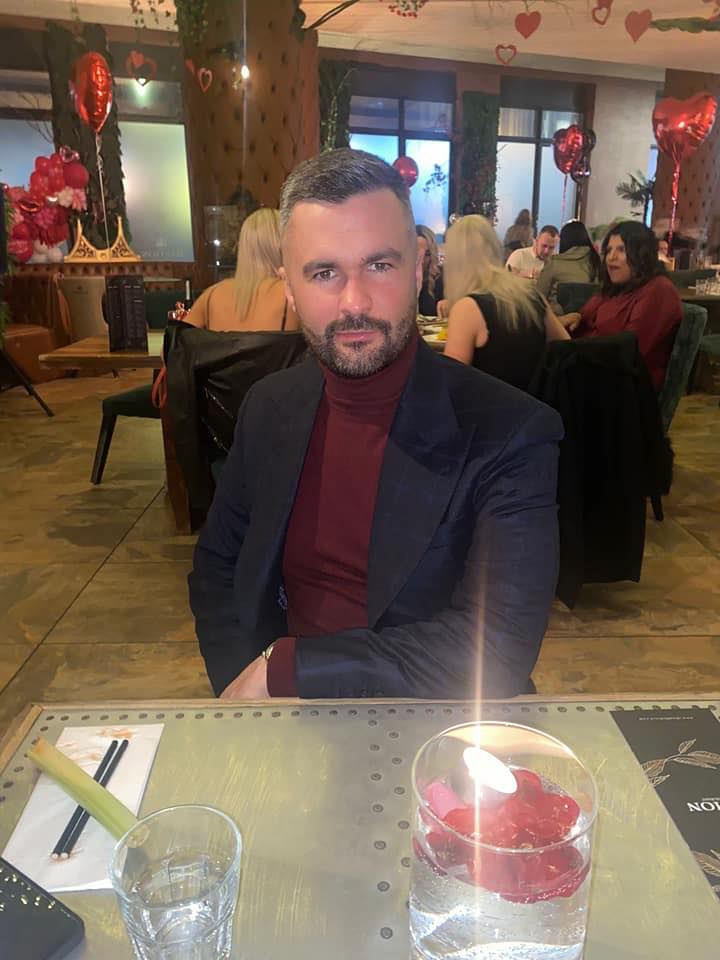

In [ ]:
image1 = Image.open(requests.get("https://scontent-lcy1-2.xx.fbcdn.net/v/t39.30808-6/274460523_10224201400335490_3863970739162568129_n.jpg?_nc_cat=104&ccb=1-6&_nc_sid=09cbfe&_nc_ohc=gPAIU1dhu7IAX_2Qs9B&_nc_ht=scontent-lcy1-2.xx&oh=00_AT8FT-rzD6SQaGeiNa-IsLqpTEyqrWG_iB28-cmpDkbeWg&oe=6280F42A", stream=True).raw)
image1 = image1.resize((720,960))
image1

And for the destination image,  thanks to Alan Turing / Kev Bramhall. 

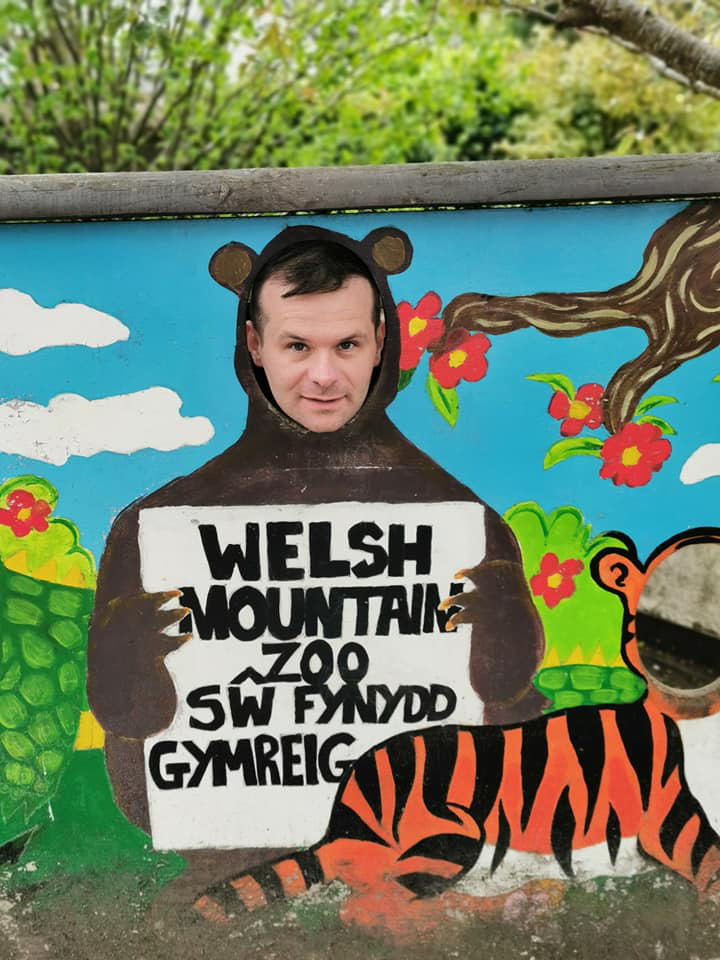

In [ ]:
image2 = Image.open(requests.get("https://scontent-lcy1-2.xx.fbcdn.net/v/t1.6435-9/190508582_10160899053139692_4087547445763458157_n.jpg?_nc_cat=103&ccb=1-6&_nc_sid=8bfeb9&_nc_ohc=agJ9oZURfxMAX9rOEqK&_nc_ht=scontent-lcy1-2.xx&oh=00_AT_u1IFYYkHy2RX2Z7DqecYgLScdO6A4fIPBPq5kVSgboQ&oe=62A438B0", stream=True).raw)
image2 = image2.resize((720,960))
image2

I will now convert the images into a numpy array and use cv2 to convert the images to greyscale.   I will also create an empty image or mask, similar to the source image with zeros. 

In [ ]:
img = np.array(image1)
img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
mask = np.zeros_like(img_grey)
img2 = np.array(image2)
img2_grey = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

I will load the face detector and shape predictor from the slib library,  I will also computer the height wideth and channels which are required for creating the empty zero image. 

In [ ]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
height, width, channels = img2.shape
img2_new_face = np.zeros((height, width, channels), np.uint8)

The following extracts the landmarks,  points x and y into a list.  Theen,  the face is segmented into triangles.  This is the core of the face swapping technique, as later we can simply exchange each triangle with the corresponding triangle of the destination image.  

The triangulation of the destination image is required to have the same patterns of the source images;  the connection points have to be the same.   

In [ ]:
# face 1
faces = detector(img_grey)
for face in faces:
  landmarks = predictor(img_grey, face)
  landmark_points = []
  for n in range(0,68):
    x = landmarks.part(n).x
    y = landmarks.part(n).y
    landmark_points.append((x,y))

  points = np.array(landmark_points, np.int32)
  convexhull = cv2.convexHull(points)
  cv2.fillConvexPoly(mask, convexhull, 255)

  face_image_1 = cv2.bitwise_and(img, img, mask=mask)

  # delaunay triangulation
  rect = cv2.boundingRect(convexhull)
  subdiv = cv2.Subdiv2D(rect)
  subdiv.insert(landmark_points)
  triangles = subdiv.getTriangleList()
  triangles = np.array(triangles, dtype=np.int32)

  indexes_triangles = []
  for t in triangles:
    pt1 = (t[0], t[1])
    pt2 = (t[2], t[3])
    pt3 = (t[4], t[5])

    index_pt1 = np.where((points == pt1).all(axis=1))
    index_pt1 = extract_index_nparray(index_pt1)
    
    index_pt2 = np.where((points == pt2).all(axis=1))
    index_pt2 = extract_index_nparray(index_pt2)

    index_pt3 = np.where((points == pt3).all(axis=1))
    index_pt3 = extract_index_nparray(index_pt3)

    if index_pt1 is not None and index_pt2 is not None and index_pt3 is not None:
      triangle = [index_pt1, index_pt2, index_pt3]
      indexes_triangles.append(triangle)

Now the same process is run for face 2.

In [ ]:
# face 2
faces2 = detector(img2_grey)
for face in faces2:
  landmarks = predictor(img2_grey, face)
  landmark_points2 = []
  for n in range(0,68):
    x = landmarks.part(n).x
    y = landmarks.part(n).y
    landmark_points2.append((x,y))

  points2 = np.array(landmark_points2, np.int32)
  convexhull2 = cv2.convexHull(points2)

Creating empty images with zeros which will be required for further processing. 

In [ ]:
lines_space_mask = np.zeros_like(img_grey)
lines_space_new_face = np.zeros_like(img2)

Now, this part is the triangulation of both faces. 

In [28]:
# Triangulation of both faces
for triangle_index in indexes_triangles:
    # Triangulation of the first face
    tr1_pt1 = landmark_points[triangle_index[0]]
    tr1_pt2 = landmark_points[triangle_index[1]]
    tr1_pt3 = landmark_points[triangle_index[2]]
    triangle1 = np.array([tr1_pt1, tr1_pt2, tr1_pt3], np.int32)


    rect1 = cv2.boundingRect(triangle1)
    (x, y, w, h) = rect1
    cropped_triangle = img[y: y + h, x: x + w]
    cropped_tr1_mask = np.zeros((h, w), np.uint8)


    points = np.array([[tr1_pt1[0] - x, tr1_pt1[1] - y],
                       [tr1_pt2[0] - x, tr1_pt2[1] - y],
                       [tr1_pt3[0] - x, tr1_pt3[1] - y]], np.int32)

    cv2.fillConvexPoly(cropped_tr1_mask, points, 255)

    # Lines space
    cv2.line(lines_space_mask, tr1_pt1, tr1_pt2, 255)
    cv2.line(lines_space_mask, tr1_pt2, tr1_pt3, 255)
    cv2.line(lines_space_mask, tr1_pt1, tr1_pt3, 255)
    lines_space = cv2.bitwise_and(img, img, mask=lines_space_mask)

    # Triangulation of second face
    tr2_pt1 = landmark_points2[triangle_index[0]]
    tr2_pt2 = landmark_points2[triangle_index[1]]
    tr2_pt3 = landmark_points2[triangle_index[2]]
    triangle2 = np.array([tr2_pt1, tr2_pt2, tr2_pt3], np.int32)


    rect2 = cv2.boundingRect(triangle2)
    (x, y, w, h) = rect2

    cropped_tr2_mask = np.zeros((h, w), np.uint8)

    points2 = np.array([[tr2_pt1[0] - x, tr2_pt1[1] - y],
                        [tr2_pt2[0] - x, tr2_pt2[1] - y],
                        [tr2_pt3[0] - x, tr2_pt3[1] - y]], np.int32)

    cv2.fillConvexPoly(cropped_tr2_mask, points2, 255)

    # Warp triangles
    points = np.float32(points)
    points2 = np.float32(points2)
    M = cv2.getAffineTransform(points, points2)
    warped_triangle = cv2.warpAffine(cropped_triangle, M, (w, h))
    warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=cropped_tr2_mask)

    # Reconstructing destination face
    img2_new_face_rect_area = img2_new_face[y: y + h, x: x + w]
    img2_new_face_rect_area_grey = cv2.cvtColor(img2_new_face_rect_area, cv2.COLOR_BGR2GRAY)
    _, mask_triangles_designed = cv2.threshold(img2_new_face_rect_area_grey, 1, 255, cv2.THRESH_BINARY_INV)
    warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=mask_triangles_designed)

    img2_new_face_rect_area = cv2.add(img2_new_face_rect_area, warped_triangle)
    img2_new_face[y: y + h, x: x + w] = img2_new_face_rect_area


Now we have cut and wrapped all the triangles I need to link them together.  I simply rebuild the face using the triangulation pattern. 

In [30]:
img2_face_mask = np.zeros_like(img2_grey)
img2_head_mask = cv2.fillConvexPoly(img2_face_mask, convexhull2, 255)
img2_face_mask = cv2.bitwise_not(img2_head_mask)

The face is now ready to be replace.   We cut out the face of the destination image to make space for the new face.  

In [31]:
img2_head_noface = cv2.bitwise_and(img2, img2, mask = img2_face_mask)
result = cv2.add(img2_head_noface, img2_new_face)

The faces have been swapped!   Now I need to adjust the colour so the source image fits the destination image.  On OpenCV there is a function called `seamlessClone` that does this operation automatically.  

In [33]:
(x, y, w, h) = cv2.boundingRect(convexhull2)
center_face2 =(int((x + x + w) / 2), int((y + y + h) / 2))
seamlessclone = cv2.seamlessClone(result, img2, img2_head_mask, center_face2, cv2.NORMAL_CLONE)

And now for the money shot.. 

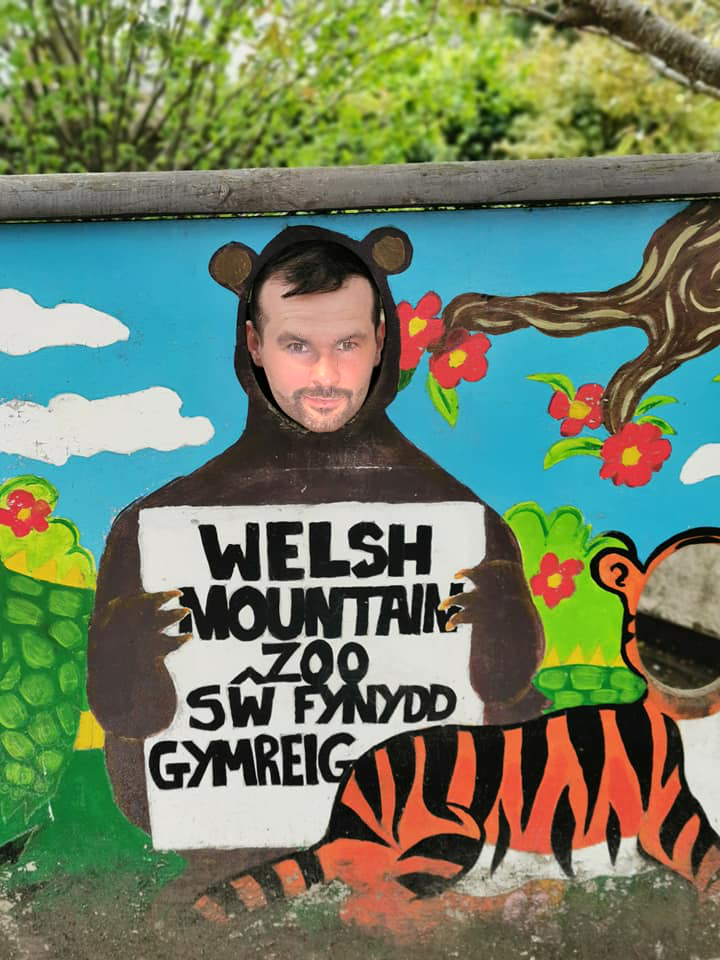

In [34]:
Image.fromarray(seamlessclone)